<a href="https://colab.research.google.com/github/RFankhauser/MSc_WI_BINA/blob/main/Datenanalyse_Test_Selina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Datenanalyse - Teil 4: Korrelation gemeinsam auftretender Wetterparameter bei Top-Verspätungen**



1.  Auswertung der Top 50 Verspätungen
2.   Daten normieren
3. Korrelationsplotter
4. Plot zu 50 Top Verspätungen inkl. auftretender normierten Wetterparameter
5. Entscheidungsbaum



## Vorbereitung:





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [4]:
import gdown

#https://drive.google.com/file/d/1nzKawzmobJgL1FYoRczZVbzWjzHzYWQU/view?usp=drive_link

# Die Datei-ID aus dem Google Drive-Link
file_id = '1nzKawzmobJgL1FYoRczZVbzWjzHzYWQU'
destination = '/content/Datensatz_komplett.csv'

# Datei herunterladen
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1nzKawzmobJgL1FYoRczZVbzWjzHzYWQU
From (redirected): https://drive.google.com/uc?id=1nzKawzmobJgL1FYoRczZVbzWjzHzYWQU&confirm=t&uuid=5fe051e4-37da-47b7-a262-40711e598566
To: /content/Datensatz_komplett.csv
100%|██████████| 1.74G/1.74G [00:19<00:00, 89.0MB/s]


'/content/Datensatz_komplett.csv'

In [5]:
# Lade die heruntergeladene CSV-Datei
df_raw = pd.read_csv('/content/Datensatz_komplett.csv')
# Zeige die ersten paar Zeilen der Datei an
display(df_raw.head(5))


,LINIEN_TEXT,HALTESTELLEN_NAME,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,VERSPAETUNG [s],WETTERSTATION,BOEENSPITZE [kmh],GLOBALSTRAHLUNG [Wm2],TEMPERATUR [°C],NIEDERSCHLAG [mm],WINDGESCHWINDIGKEIT [kmh],NEUSCHNEEHOEHE [cm],SCHNEEHOEHE_MORGENMESSUNG_6_UTC [cm],TAG_MIT_HAGEL,TAG_MIT_NEBEL,GPS_LATITUDE,GPS_LONGITUDE
0,10,"Zürich, Salersteig",2024-01-01 04:36:00,2024-01-01 04:37:09,REAL,69.0,NABZUE,50.4,0.0,4.9,1.1,15.5,0.0,0.0,0.0,0.0,47.406052,8.548386
1,10,"Zürich, Berninaplatz",2024-01-01 04:37:00,2024-01-01 04:38:08,REAL,68.0,NABZUE,50.4,0.0,4.9,1.1,15.5,0.0,0.0,0.0,0.0,47.403601,8.547871
2,10,"Zürich, Hirschwiesenstrasse",2024-01-01 04:38:00,2024-01-01 04:39:12,REAL,72.0,NABZUE,50.4,0.0,4.9,1.1,15.5,0.0,0.0,0.0,0.0,47.400376,8.543683
3,10,"Zürich, Milchbuck",2024-01-01 04:40:00,2024-01-01 04:42:18,REAL,138.0,NABZUE,50.4,0.0,4.9,1.1,15.5,0.0,0.0,0.0,0.0,47.398125,8.542047
4,10,"Zürich, Universität Irchel",2024-01-01 04:41:00,2024-01-01 04:44:07,REAL,187.0,NABZUE,50.4,0.0,4.9,1.1,15.5,0.0,0.0,0.0,0.0,47.396090,8.545105


# Daten-Normierung

In [6]:
# Formel Normierung xneu = (x - xmin) / (xmax - xmin)
#MinMax ausrechnen
scaler = MinMaxScaler()

# Nur  Spalten auswählen, die zu normieren sind
spalten = ['TEMPERATUR [°C]', 'NIEDERSCHLAG [mm]','WINDGESCHWINDIGKEIT [kmh]', 'NEUSCHNEEHOEHE [cm]' ]

df_norm = df_raw.copy()

# Normierung der Daten
df_norm[spalten] = scaler.fit_transform(df_norm[spalten])

# Ergebnis ansehen
display(df_norm.head())

,LINIEN_TEXT,HALTESTELLEN_NAME,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,VERSPAETUNG [s],WETTERSTATION,BOEENSPITZE [kmh],GLOBALSTRAHLUNG [Wm2],TEMPERATUR [°C],NIEDERSCHLAG [mm],WINDGESCHWINDIGKEIT [kmh],NEUSCHNEEHOEHE [cm],SCHNEEHOEHE_MORGENMESSUNG_6_UTC [cm],TAG_MIT_HAGEL,TAG_MIT_NEBEL,GPS_LATITUDE,GPS_LONGITUDE
0,10,"Zürich, Salersteig",2024-01-01 04:36:00,2024-01-01 04:37:09,REAL,69.0,NABZUE,50.4,0.0,0.251889,0.094017,0.476351,0.0,0.0,0.0,0.0,47.406052,8.548386
1,10,"Zürich, Berninaplatz",2024-01-01 04:37:00,2024-01-01 04:38:08,REAL,68.0,NABZUE,50.4,0.0,0.251889,0.094017,0.476351,0.0,0.0,0.0,0.0,47.403601,8.547871
2,10,"Zürich, Hirschwiesenstrasse",2024-01-01 04:38:00,2024-01-01 04:39:12,REAL,72.0,NABZUE,50.4,0.0,0.251889,0.094017,0.476351,0.0,0.0,0.0,0.0,47.400376,8.543683
3,10,"Zürich, Milchbuck",2024-01-01 04:40:00,2024-01-01 04:42:18,REAL,138.0,NABZUE,50.4,0.0,0.251889,0.094017,0.476351,0.0,0.0,0.0,0.0,47.398125,8.542047
4,10,"Zürich, Universität Irchel",2024-01-01 04:41:00,2024-01-01 04:44:07,REAL,187.0,NABZUE,50.4,0.0,0.251889,0.094017,0.476351,0.0,0.0,0.0,0.0,47.396090,8.545105


# Auswahl und Sortierung der maximalen (50) Verspätungen im 2024.
Top 50 Auswahl aus der Normierung-Dataframe

top50_norm = normiertere Werte, die nach top 50 Verspätung ausgewertet wurden

In [9]:
#aufsteigend nach der Spalte Verspätungen sortiert.Basierend auf dem Dataframe aus der Normierung.
df_sorted = df_norm.sort_values(by='VERSPAETUNG [s]' , ascending=True)
#aus dem sortierten Dataframe werden die 50 letzten Zeile entnommen. Das entspricht also den 50 grössten Verspätungen. (da aufsteigend sortiert wurde)
top50_norm=df_sorted.tail(50)
#Anzeigen der ersten 5 Zeilen - somit die 5 kleinsten Verspätungen
display(top50_norm.head())

,LINIEN_TEXT,HALTESTELLEN_NAME,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,VERSPAETUNG [s],WETTERSTATION,BOEENSPITZE [kmh],GLOBALSTRAHLUNG [Wm2],TEMPERATUR [°C],NIEDERSCHLAG [mm],WINDGESCHWINDIGKEIT [kmh],NEUSCHNEEHOEHE [cm],SCHNEEHOEHE_MORGENMESSUNG_6_UTC [cm],TAG_MIT_HAGEL,TAG_MIT_NEBEL,GPS_LATITUDE,GPS_LONGITUDE
8327918,11,"Zürich, Signaustrasse",2024-11-21 17:46:00,2024-11-21 18:15:56,REAL,1796.0,NABZUE,21.2,-2.0,0.125945,0.333333,0.158784,1.0,0.0,0.0,0.0,47.362999,8.557869
6817401,4,"Zürich, Sportweg",2024-02-18 21:37:00,2024-02-18 22:06:56,GESCHAETZT,1796.0,NABZUE,19.8,0.0,0.377834,0.042735,0.341216,0.0,0.0,0.0,1.0,47.391536,8.506120
8331395,7,"Zürich, Glattwiesen",2024-11-21 19:00:00,2024-11-21 19:29:56,REAL,1796.0,NABZUE,15.8,-4.0,0.130982,0.111111,0.111486,1.0,0.0,0.0,0.0,47.401474,8.581610
289462,13,"Zürich, Letzigrund",2024-11-01 05:35:00,2024-11-01 06:04:56,GESCHAETZT,1796.0,NABZUE,10.4,-4.0,0.362720,0.000000,0.111486,0.0,0.0,0.0,0.0,47.381387,8.503520
11800498,11,"Zürich, Hedwigsteig",2024-08-30 07:14:00,2024-08-30 07:43:56,GESCHAETZT,1796.0,NABZUE,7.2,225.0,0.657431,0.000000,0.074324,0.0,0.0,0.0,0.0,47.360386,8.564831


# Korrelationsplot

Ein hoher positiver Wert (nahe +1) deutet auf eine starke positive Korrelation hin, während ein hoher negativer Wert (nahe -1) auf eine starke negative Korrelation hinweist. Werte nahe 0 deuten auf keine oder nur geringe lineare Korrelation hin.

korrelation = Korrelation zwischen den Werten von top50_norm Dataframe mit festgelegten Wetter Spalten

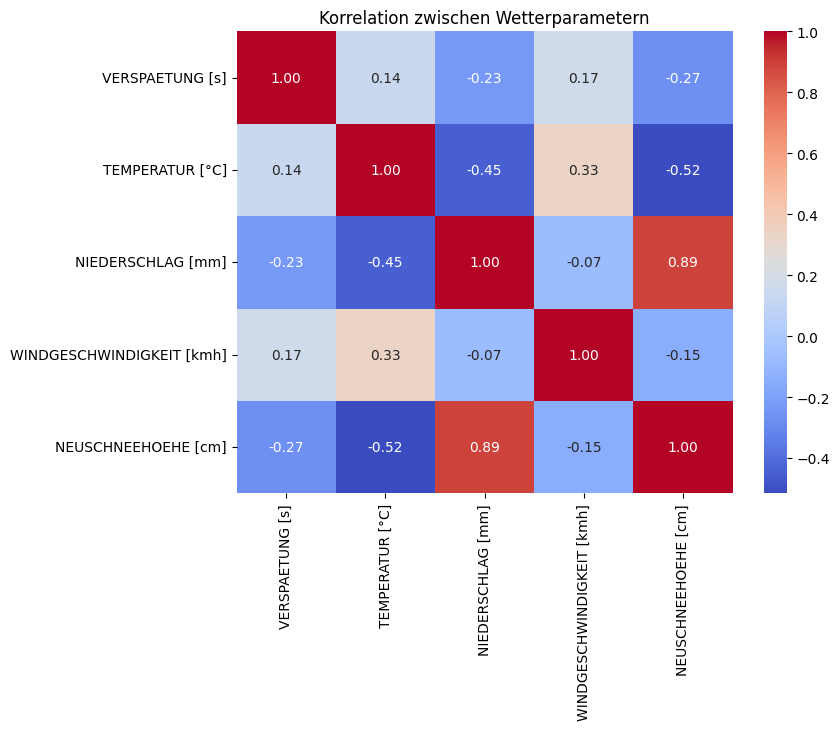

In [10]:
#Auswahl der Wetterparameter, die untersucht werden
wetter_spalten = ['VERSPAETUNG [s]','TEMPERATUR [°C]','NIEDERSCHLAG [mm]', 'WINDGESCHWINDIGKEIT [kmh]', 'NEUSCHNEEHOEHE [cm]']

#Aus dem ursprünglichen DataFrame top50 wird ein neuer DataFrame wetter_df gebildet, der nur die oben genannten Wetterspalten enthäl
wetter_df = top50_norm[wetter_spalten]

#Berechnung der Korrelationsmatrix
korrelation = wetter_df.corr()

#Heatmap zeichnen
plt.figure(figsize=(8, 6))
sns.heatmap(korrelation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelation zwischen Wetterparametern")
plt.show()

**Ergebnis**
Gemäss dem Korrelaitonsplot gibt es sehr geringe Korrelation zwischen den 50 grössten Verspätung und den den Wetterparameter

# Plot

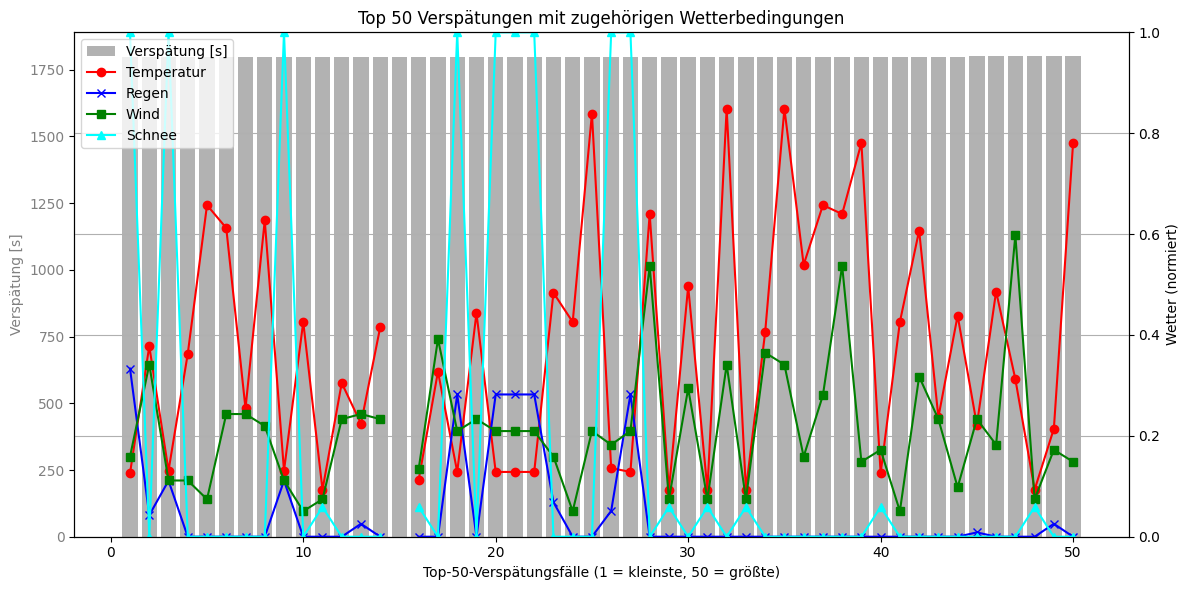

In [13]:
#Verspätungsindex von 1-50 auf der x-Achse
x = range(1,51)
fig, ax1 = plt.subplots(figsize=(12, 6))


# Linke Y-Achse: Balkendiagramm für Verspätungen
ax1.bar(x, top50_norm['VERSPAETUNG [s]'], label='Verspätung [s]', alpha=0.6, color='gray')
ax1.set_ylabel('Verspätung [s]', color='gray')
ax1.set_xlabel('Top-50-Verspätungsfälle (1 = kleinste, 50 = größte)')
ax1.tick_params(axis='y', labelcolor='gray')

# Rechte Y-Achse: Wetterparameter
ax2 = ax1.twinx()
ax2.plot(x, top50['TEMPERATUR [°C]'], label='Temperatur', color='red', marker='o')
ax2.plot(x, top50['NIEDERSCHLAG [mm]'], label='Regen', color='blue', marker='x')
ax2.plot(x, top50['WINDGESCHWINDIGKEIT [kmh]'], label='Wind', color='green', marker='s')
ax2.plot(x, top50['NEUSCHNEEHOEHE [cm]'], label='Schnee', color='cyan', marker='^')
ax2.set_ylabel('Wetter (normiert)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1)  # Da normiert

# Legenden zusammenführen
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Top 50 Verspätungen mit zugehörigen Wetterbedingungen')
plt.grid(True)
plt.tight_layout()
plt.show()

# Ergebnis/ Analyse des Plotters

**Schnee**
Entweder hat Schnee fast kein Impact auf die Verspätungen ausser bei den 6 Auswirkungen.

**Temperatur**
Lässt sich keine klare Korrelation erkennbar

**Regen**
Lässt sich keine klare Korrelation erkennbar. Gibt oft wenig Regen, aber sehr hohe Verspätung

**Wind**
keine Korrelation erkennbar

# Erstellung eines Entscheidungsbaum

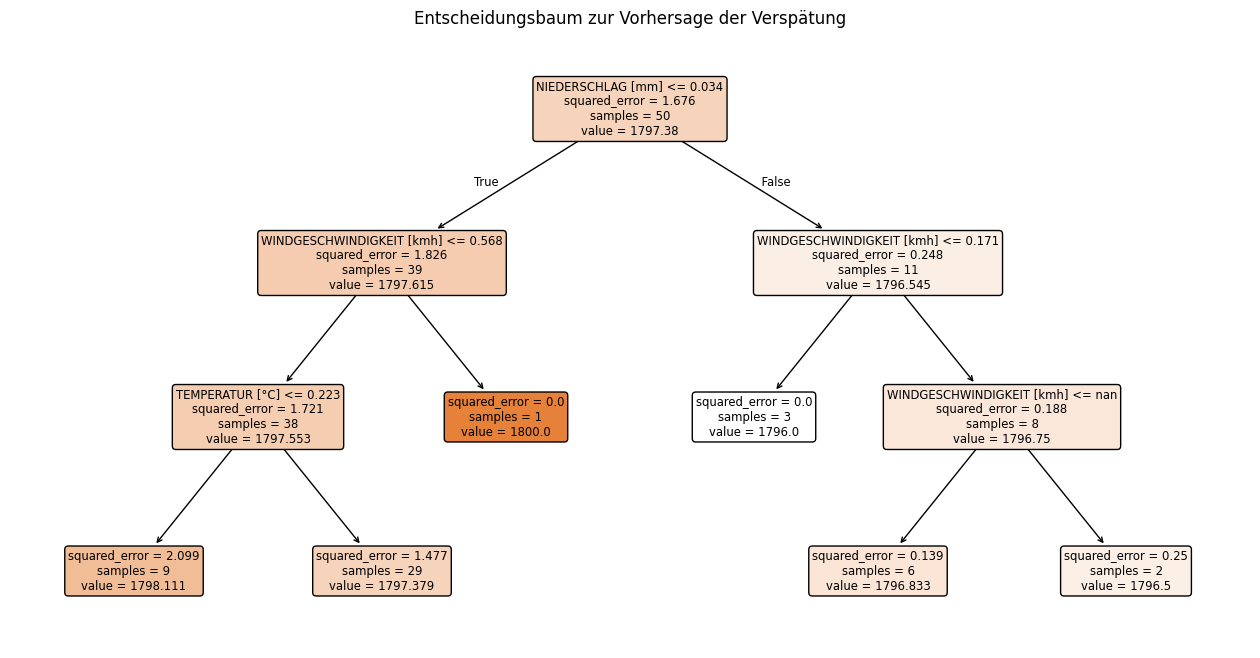

In [20]:
X = top50_norm[['TEMPERATUR [°C]', 'NIEDERSCHLAG [mm]', 'WINDGESCHWINDIGKEIT [kmh]', 'NEUSCHNEEHOEHE [cm]']]
y = top50_norm['VERSPAETUNG [s]']

baum = DecisionTreeRegressor(max_depth=3)
baum.fit(X, y)

plt.figure(figsize=(16, 8))
plot_tree(baum, feature_names=X.columns, filled=True, rounded=True)
plt.title("Entscheidungsbaum zur Vorhersage der Verspätung")
plt.show()

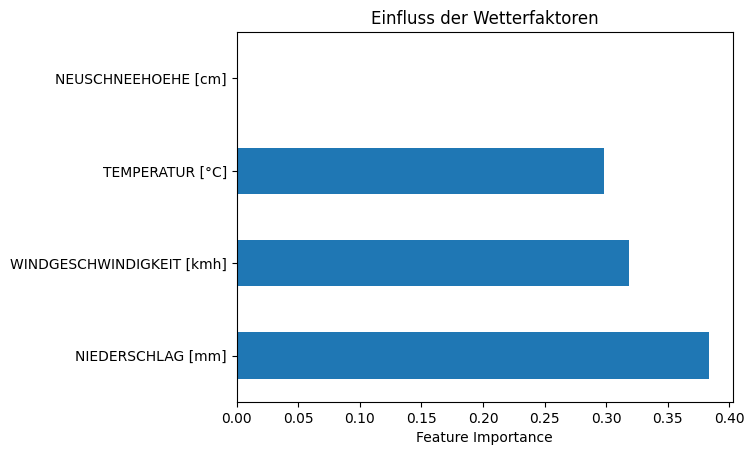

In [19]:
wichtigkeit = pd.Series(baum.feature_importances_, index=X.columns)
wichtigkeit.sort_values(ascending=False).plot(kind='barh', title='Einfluss der Wetterfaktoren')
plt.xlabel('Feature Importance')
plt.show()